<div align="center">
<font size="5">__Notebook for testing the reconstrcution of LST1 data.__</font>
<br><br>
<font size="4">This Notebook shows the steps followed within cta-lstchain to reconstruct event data from a corsika-simtelarray file to a dl2 data level, with reconstructed energy, direction and gamma/hadron separation.</font>
<font size="4">
To run this notebook you will need the last version of cta-lstchain:

git clone https://github.com/cta-observatory/cta-lstchain
<br>
<br>
**If you have ctapipe already installed in a conda environment:**
<br><br>
source activate cta-dev
<br>
python setup.py install
<br>
<font size="4">
**If you don't have ctapipe installed:**</font>
<br><br>
conda env create -f environment.yml
<br>
source activate cta-dev
<br>
python setup.py install

Also, you will need the datafiles from **cta-lstchain-extra:**

git clone https://github.com/cta-observatory/cta-lstchain-extra

although the trained models can also be found in ~/lst-chain/notebooks


<font size="4">
    **Some imports...**

In [1]:
from sklearn.externals import joblib
from ctapipe.utils import get_dataset_path
from lstchain.io.config import get_standard_config
from copy import copy
import matplotlib.pyplot as plt
import os
import pandas as pd
import lstchain.reco.dl0_to_dl1 as calib
import lstchain.reco.dl1_to_dl2 as reco
import lstchain.visualization.plot_dl2 as lstplot
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 14

/Users/garciaenrique/anaconda3/envs/cta-dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<font size="4">
**Import a simtelarray file of MC simulated data:**

In [2]:
#datafile = get_dataset_path('gamma_test_large.simtel.gz')

# Local files can be also imported.
datafile = "/Users/garciaenrique/CTA/data/LST_mono_Simtel/gamma-diffuse_20deg_180deg_run9___cta-prod3-demo-2147m-LaPalma-baseline-mono.simtel.gz"

<font size="4">
**Calibration and parameters extraction**
    <br><br>
    We have a function for extracting all the image information:
    
    - Charge extraction
    - Cleaning
    - Hillas Parameters
    - Timing parameters

We store this information in a custom container which we write into a **hdf5** file.

In [3]:
#Limit the number of events to analyze, to speed the examples, if desired.
#calib.max_events = 1000 
calib.r0_to_dl1(datafile)
output_filename = 'dl1_' + os.path.basename(datafile).split('.')[0] + '.h5'

0


/Users/garciaenrique/anaconda3/envs/cta-dev/lib/python3.7/site-packages/ctapipe/image/hillas.py:141: RuntimeWarning: invalid value encountered in sqrt
  width, length = np.sqrt(eig_vals)


100
200
300
400
500
600
700
800
900
1000
1100
1200


<font size="4">
We can read this file as a **pandas dataframe**:

In [4]:
#Take a look at the parameters extracted from the simtelarray file:
data = pd.read_hdf(output_filename,key='events/LSTCam')
print(data.keys())

Index(['disp_angle', 'disp_dx', 'disp_dy', 'disp_miss', 'disp_norm',
       'disp_sign', 'event_id', 'gps_time', 'intensity', 'intercept',
       'kurtosis', 'leakage', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az',
       'mc_az_tel', 'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'n_islands', 'obs_id', 'phi',
       'psi', 'r', 'skewness', 'src_x', 'src_y', 'tel_id', 'tel_pos_x',
       'tel_pos_y', 'tel_pos_z', 'time_gradient', 'width', 'wl', 'x', 'y'],
      dtype='object')


In [5]:
data.head()

,disp_angle,disp_dx,disp_dy,disp_miss,disp_norm,disp_sign,event_id,gps_time,intensity,intercept,...,src_y,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,time_gradient,width,wl,x,y
0,0.683890,-0.178164,-0.145224,0.165438,0.229853,-1.0,307,1.555491e+09,1.805339,17.342942,...,0.889907,3,75.279999,50.490002,39.700001,-1.378181,0.054662,0.828008,-0.191135,1.035132
1,-0.566675,-0.138771,0.088298,0.077092,0.164481,-1.0,2005,1.555492e+09,1.592848,18.255218,...,0.833633,3,75.279999,50.490002,39.700001,-0.359745,0.034504,0.534081,0.519070,0.745335
2,0.357477,-0.252893,-0.094462,0.040368,0.269959,-1.0,2005,1.555492e+09,1.700820,17.614086,...,0.833633,4,30.910000,-64.540001,43.000000,-3.064171,0.048735,0.744819,0.633192,0.928095
3,1.194509,-0.482495,-1.221152,0.081645,1.313017,-1.0,14905,1.555492e+09,2.492302,17.000050,...,-0.571984,2,-35.270000,66.139999,43.000000,-1.570015,0.153753,0.356107,-0.081826,0.649167
4,1.449989,-0.150046,-1.235975,0.039492,1.245049,-1.0,14905,1.555492e+09,2.502508,16.860371,...,-0.571984,3,75.279999,50.490002,39.700001,0.277576,0.075659,0.209409,-0.414276,0.663990


<font size="4">
**We can take a look at some of these features...**
    <br><br>
    **Energy**

In [6]:
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 14

Text(0.5, 0, '$log_{10} mcEnergy$ (MeV)')

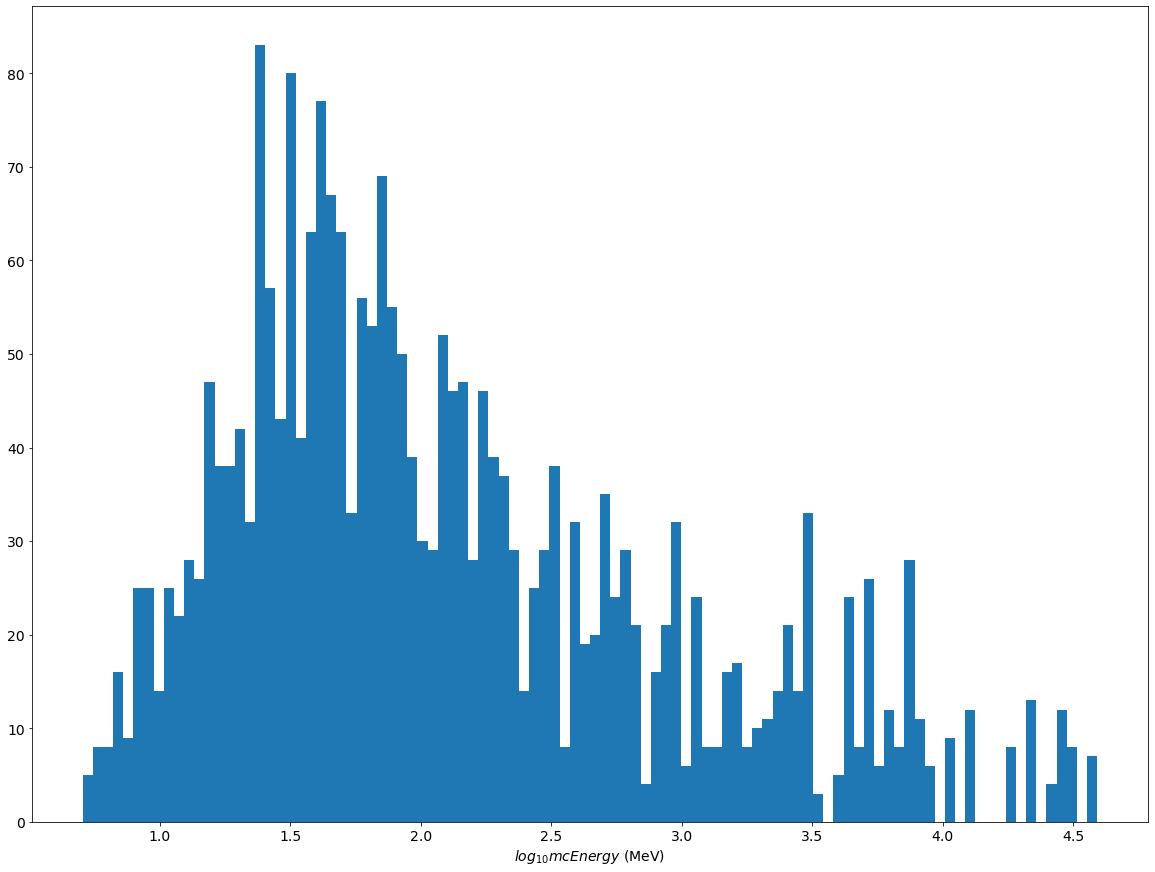

In [7]:
#We can plot some distributions:
plt.hist(data['mc_energy'],bins=100) #Log10(Energy) in MeV
plt.xlabel('$log_{10} mcEnergy$ (MeV)')

<font size="4">
**Intensity**

Text(0.5, 0, '$log_{10} intensity$')

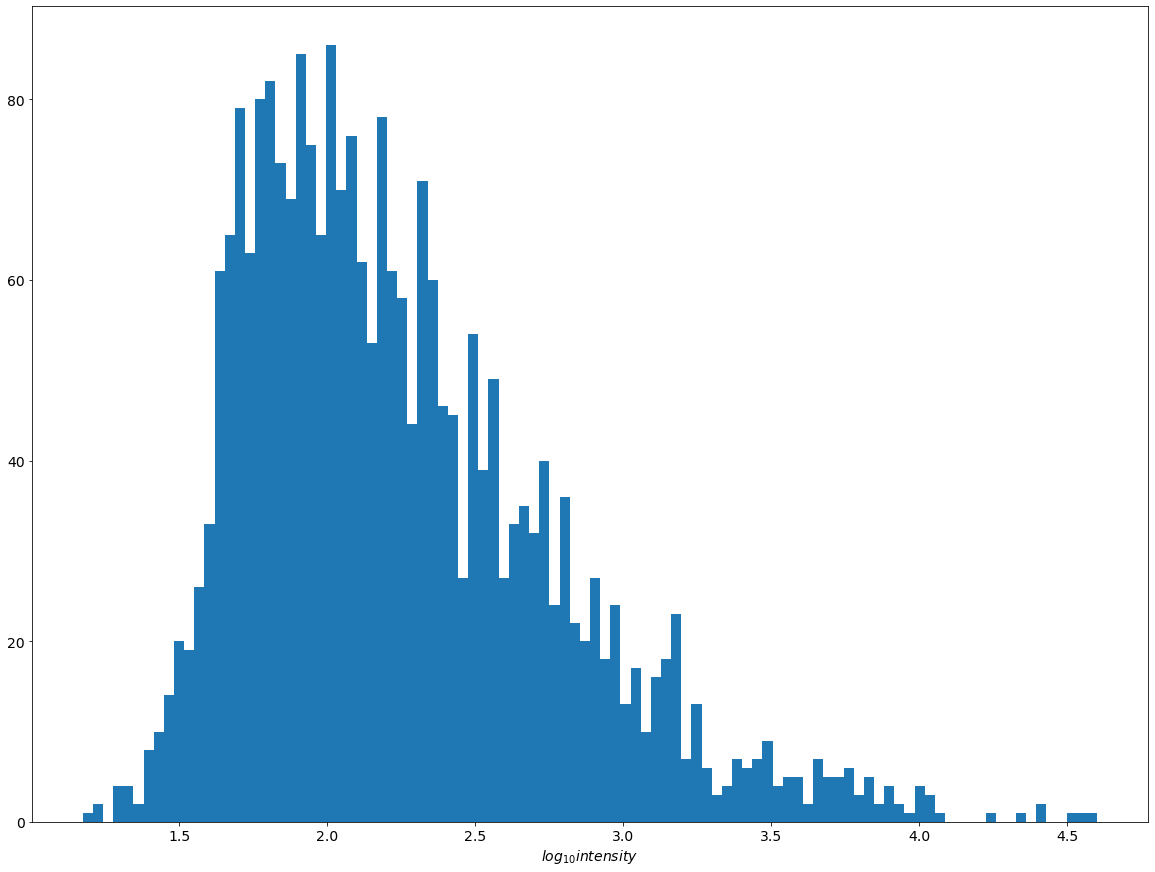

In [8]:
plt.hist(data['intensity'],bins=100) #Log10(intensity(size))
plt.xlabel('$log_{10} intensity$')

<font size="4">
**Width**

Text(0.5, 0, 'width (º)')

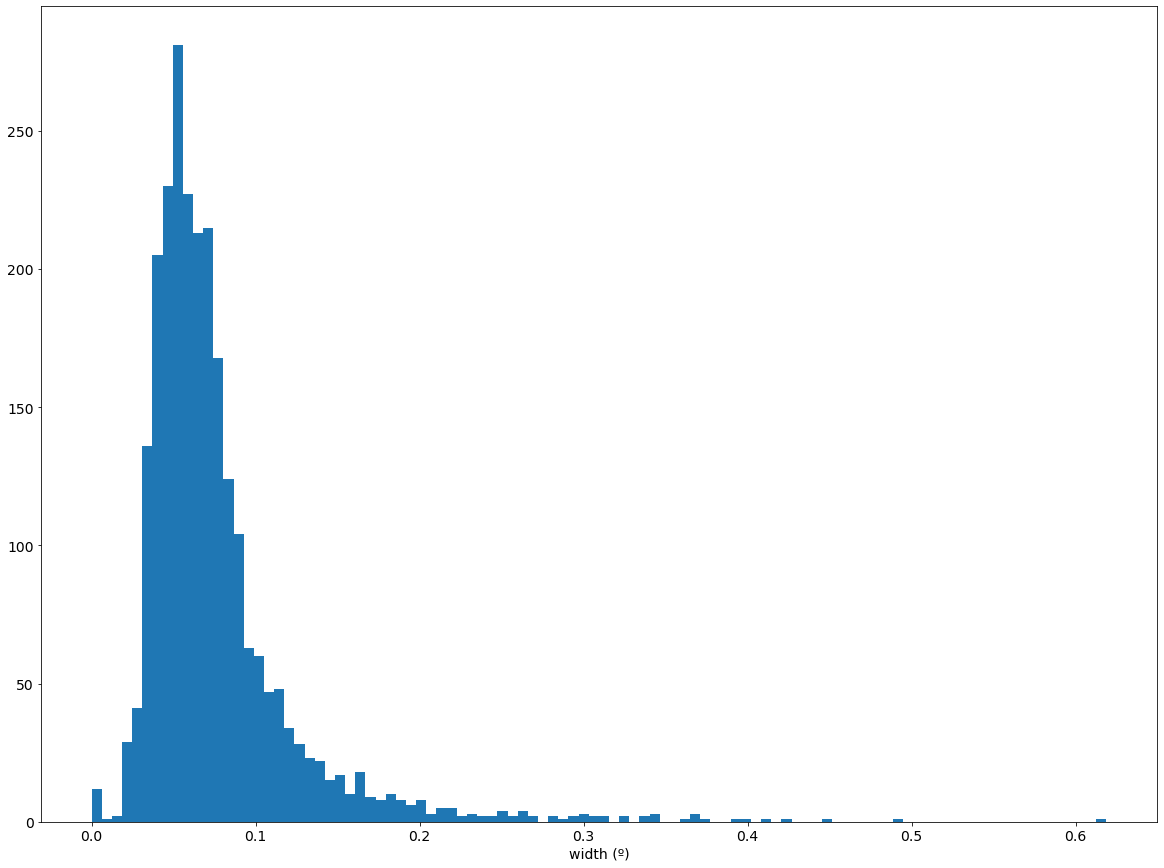

In [9]:
plt.hist(data['width'],bins=100) #Width in deg.
plt.xlabel('width (º)')

<font size="4">
**Length**

Text(0.5, 0, 'length (º)')

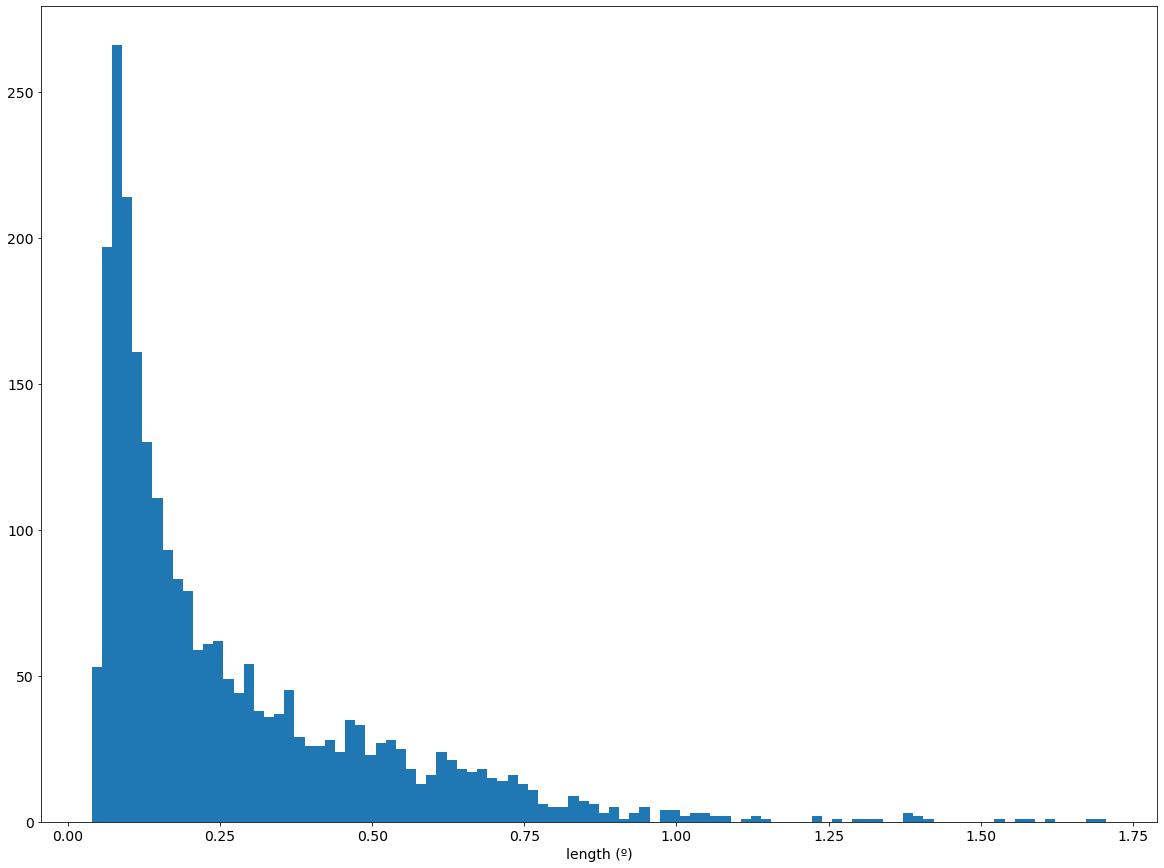

In [10]:
plt.hist(data['length'],bins=100) #Length in deg. 
plt.xlabel('length (º)')

<font size="4">
    **Source position in camera coordinates**

Text(0, 0.5, 'y (m)')

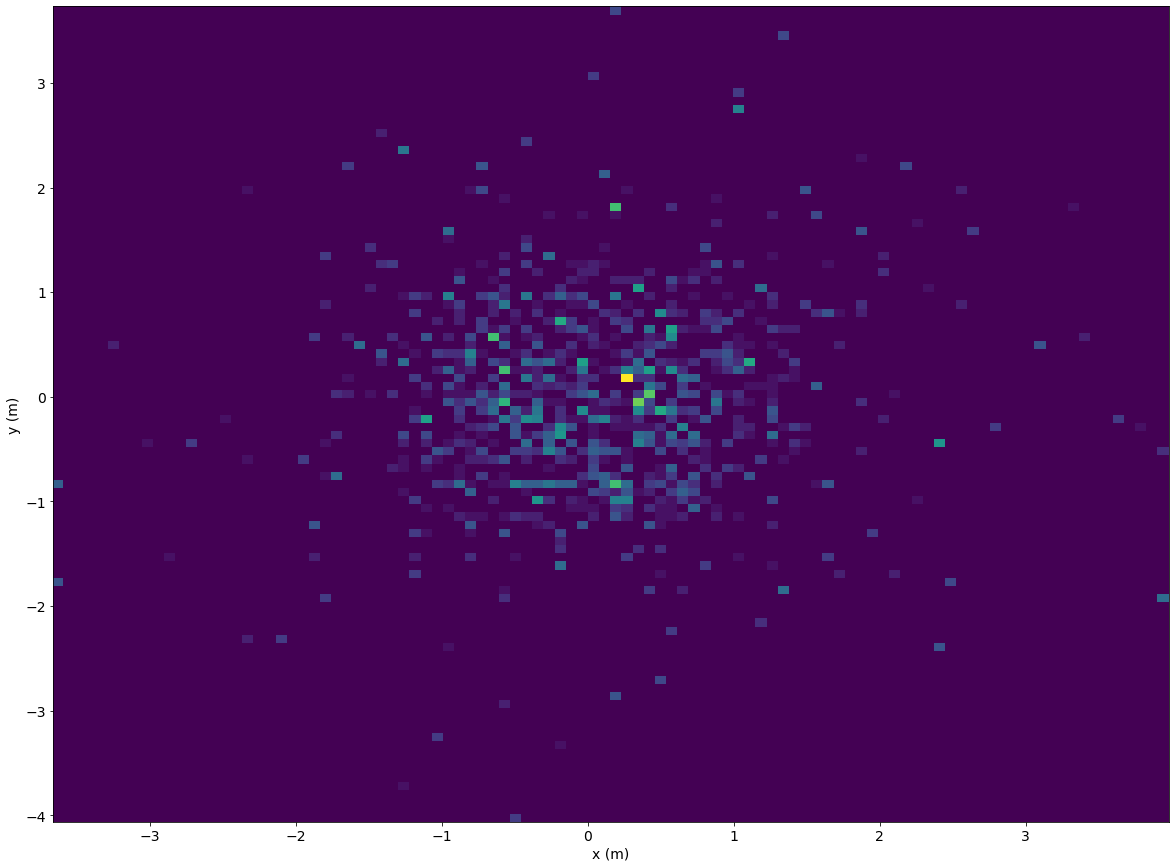

In [11]:
plt.hist2d(data['src_x'],data['src_y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

<font size="4">
**Cengter of gravity of Hillas ellipse in camera coordinates**

Text(0, 0.5, 'y (m)')

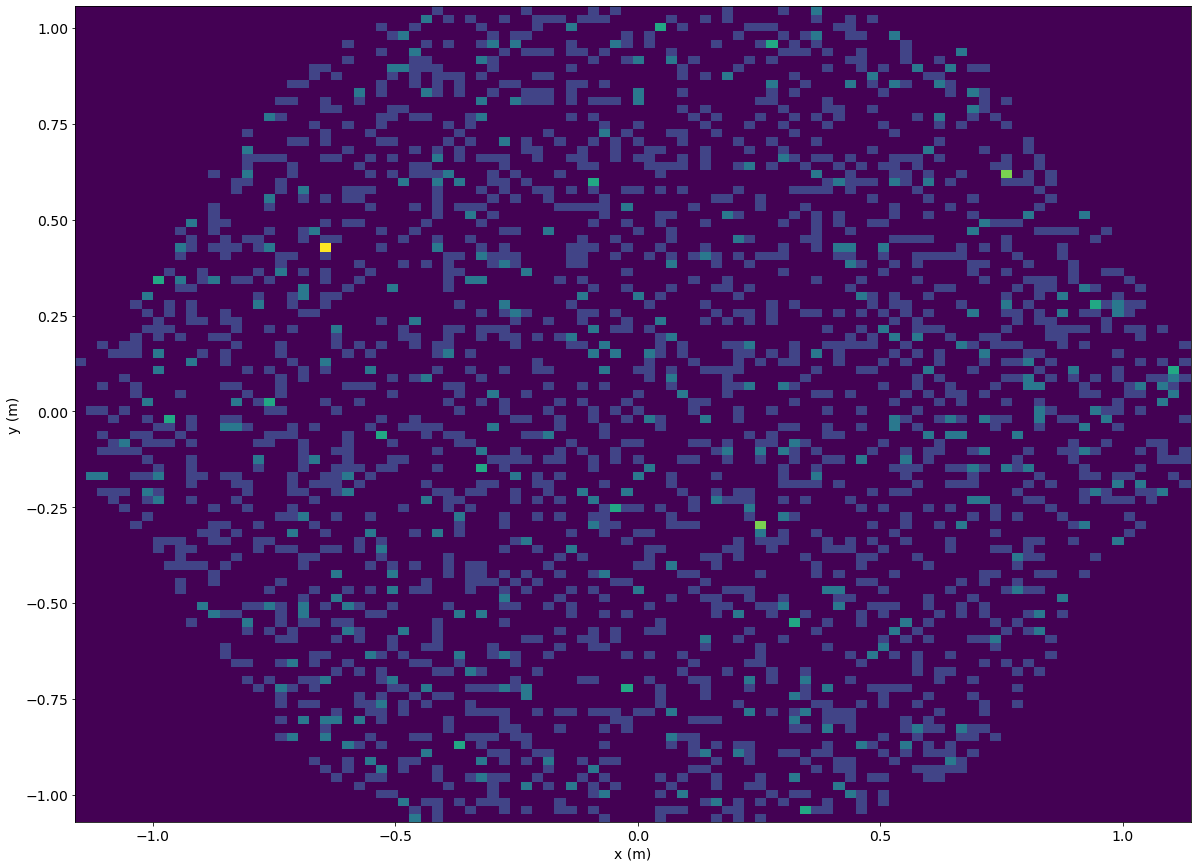

In [12]:
plt.hist2d(data['x'],data['y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

<font size="4">
**Import the Random Forests previously trained**

In [13]:
path_models = "." # if you are in ~/lstchain/notebooks

# Otherwise declare the correct path to the models
#path_models = "../../cta-lstchain-extra/reco/models"  

fileE = path_models + "/RFreg_Energy.sav"                                                            
fileD = path_models + "/RFreg_Disp.sav"                                                              
fileH = path_models + "/RFcls_GH.sav"                                                                

RFreg_Energy = joblib.load(fileE)                                                                         
RFreg_Disp = joblib.load(fileD)                                                                           
RFcls_GH = joblib.load(fileH)


<font size="4">
**Features for prediction:**

In [14]:
# We are going to take them from the standard configuration

config = get_standard_config()
config['regression_features']

['intensity',
 'width',
 'length',
 'x',
 'y',
 'psi',
 'phi',
 'wl',
 'skewness',
 'kurtosis',
 'r',
 'time_gradient',
 'intercept',
 'leakage',
 'n_islands']

<font size="4">
Now we can apply the Random Forests to the data and reconsctruct the energy, direction and Gamma/Hadron classification

In [15]:
#Now we have the trained RF that we can use to reconstruct our data into dl2 format:
data_dl2 = reco.apply_models(data, 
                             RFcls_GH, 
                             RFreg_Energy, 
                             RFreg_Disp, 
                             config)
print(data_dl2.keys())

Index(['disp_angle', 'disp_dx', 'disp_dy', 'disp_miss', 'disp_norm',
       'disp_sign', 'event_id', 'gps_time', 'intensity', 'intercept',
       'kurtosis', 'leakage', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az',
       'mc_az_tel', 'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'n_islands', 'obs_id', 'phi',
       'psi', 'r', 'skewness', 'src_x', 'src_y', 'tel_id', 'tel_pos_x',
       'tel_pos_y', 'tel_pos_z', 'time_gradient', 'width', 'wl', 'x', 'y',
       'reco_energy', 'reco_disp_dx', 'reco_disp_dy', 'src_x_rec', 'src_y_rec',
       'reco_type', 'gammaness'],
      dtype='object')


<font size="4">
**Plot the results**
    <br><br>
    
**Features:**
<br><br>
Since we were using a file only with gamma events, here we can notice the events that has been badly classified as protons.    

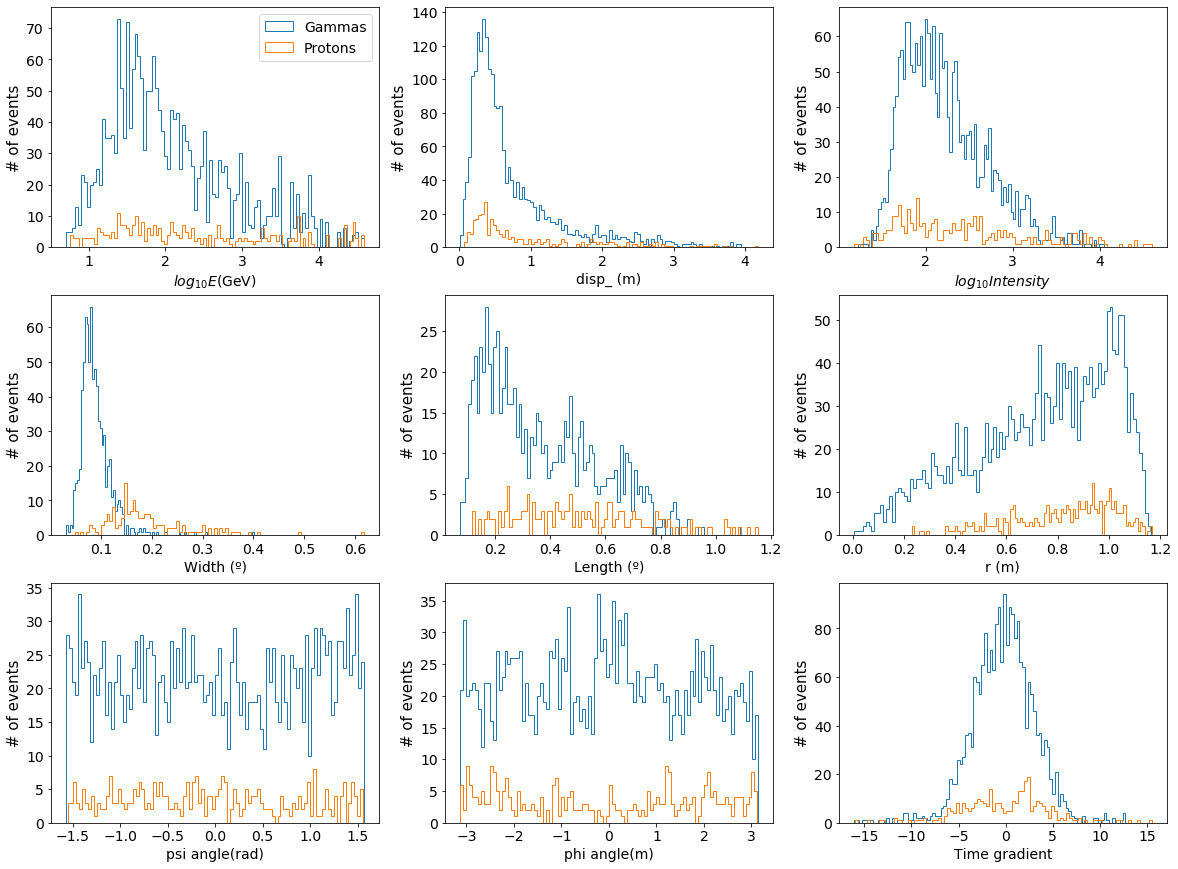

In [16]:
#Lets take a look to the results
lstplot.plot_features(data_dl2)

<font size="4">
**Energy reconstruction**

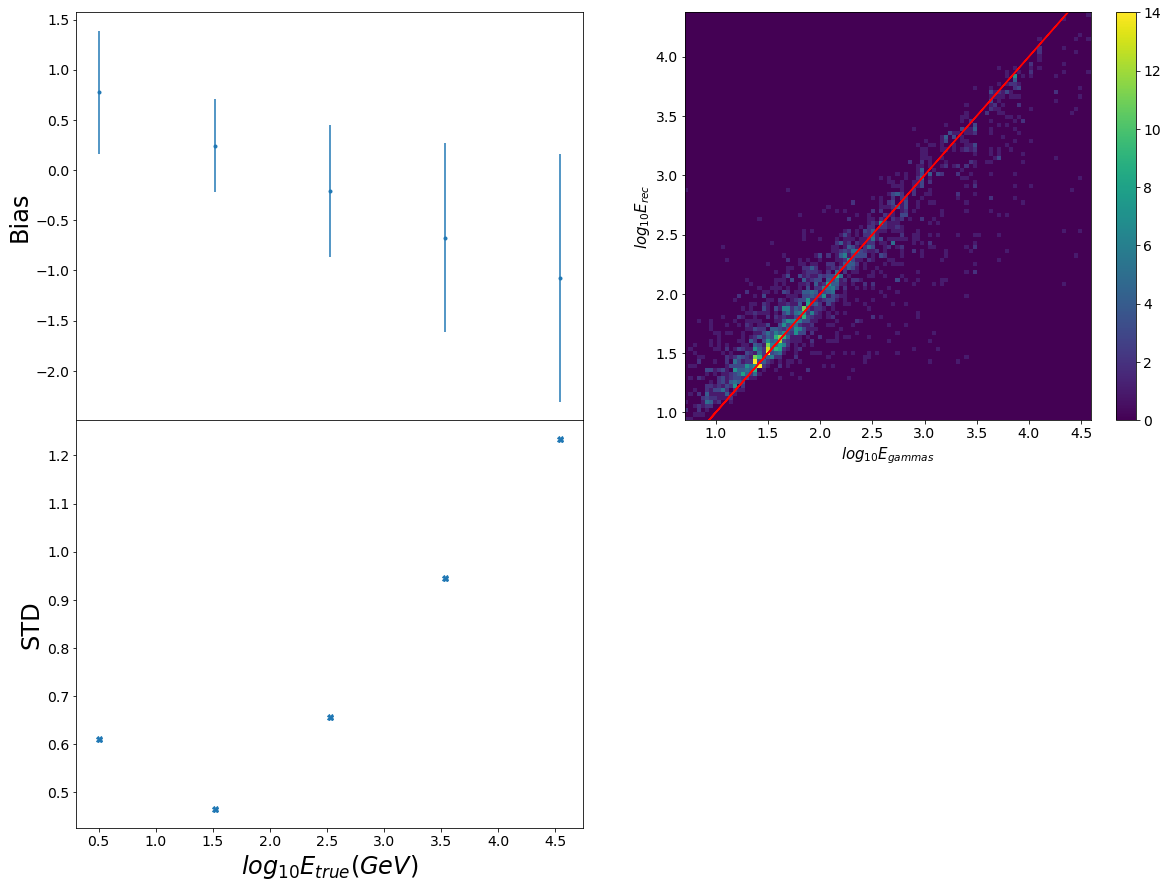

In [17]:
lstplot.plot_e(data_dl2,n_bins=100, emin=data_dl2.reco_type.min(), emax=data_dl2.reco_type.max())

<font size="4">
**Disp reconstruction**

mu = 0.20112981824812814
 sigma = 0.20613718083686353


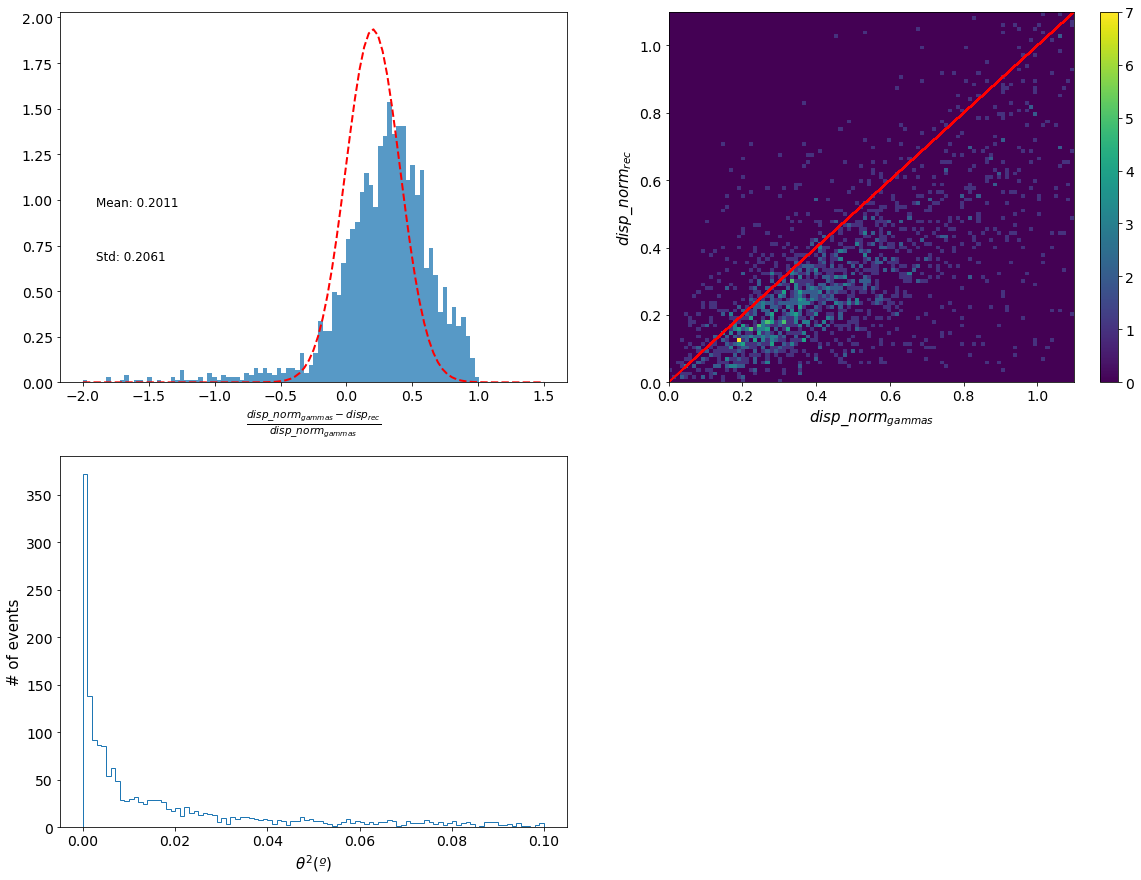

In [18]:
lstplot.plot_disp(data_dl2)

<font size="4">
**Reconstructed source position in camera coordinates**

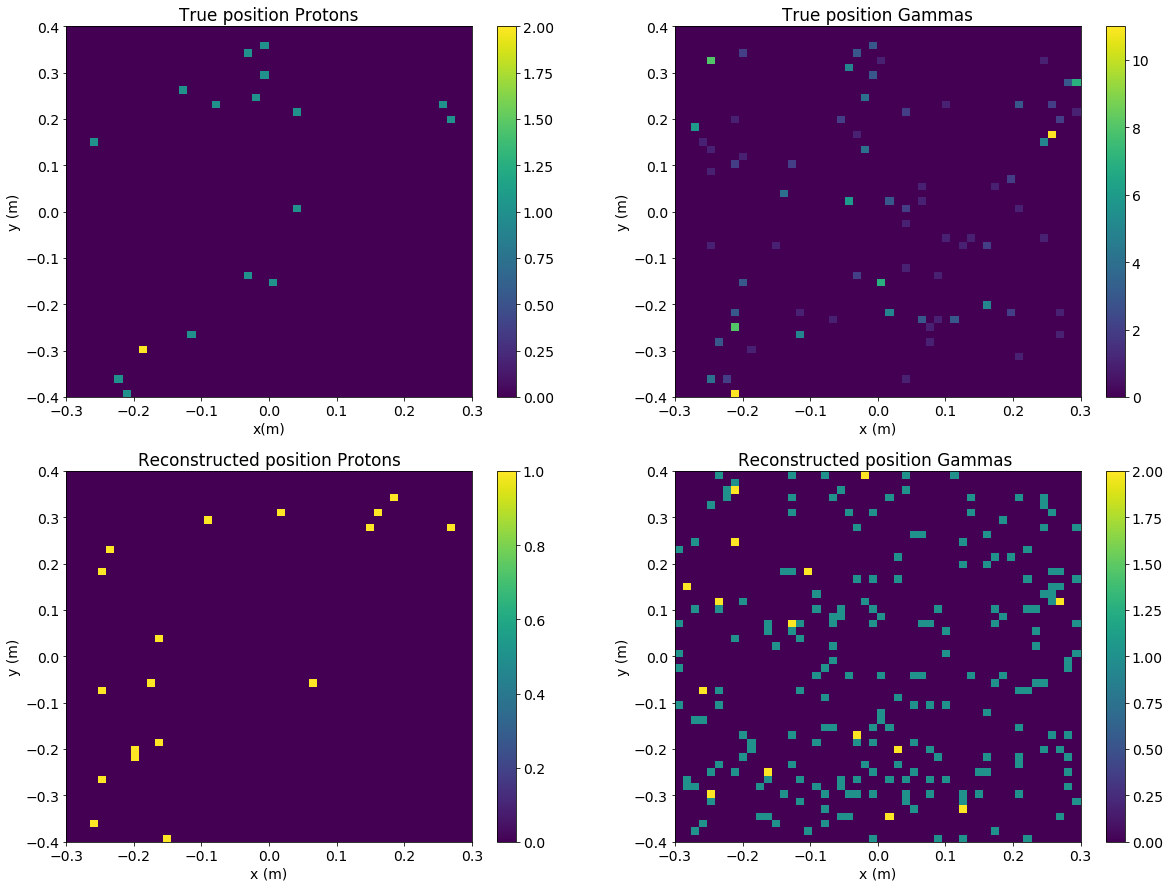

In [19]:
lstplot.plot_pos(data_dl2)

<font size="4">
**RHadroness**

Text(0.5, 0, 'Hadroness')

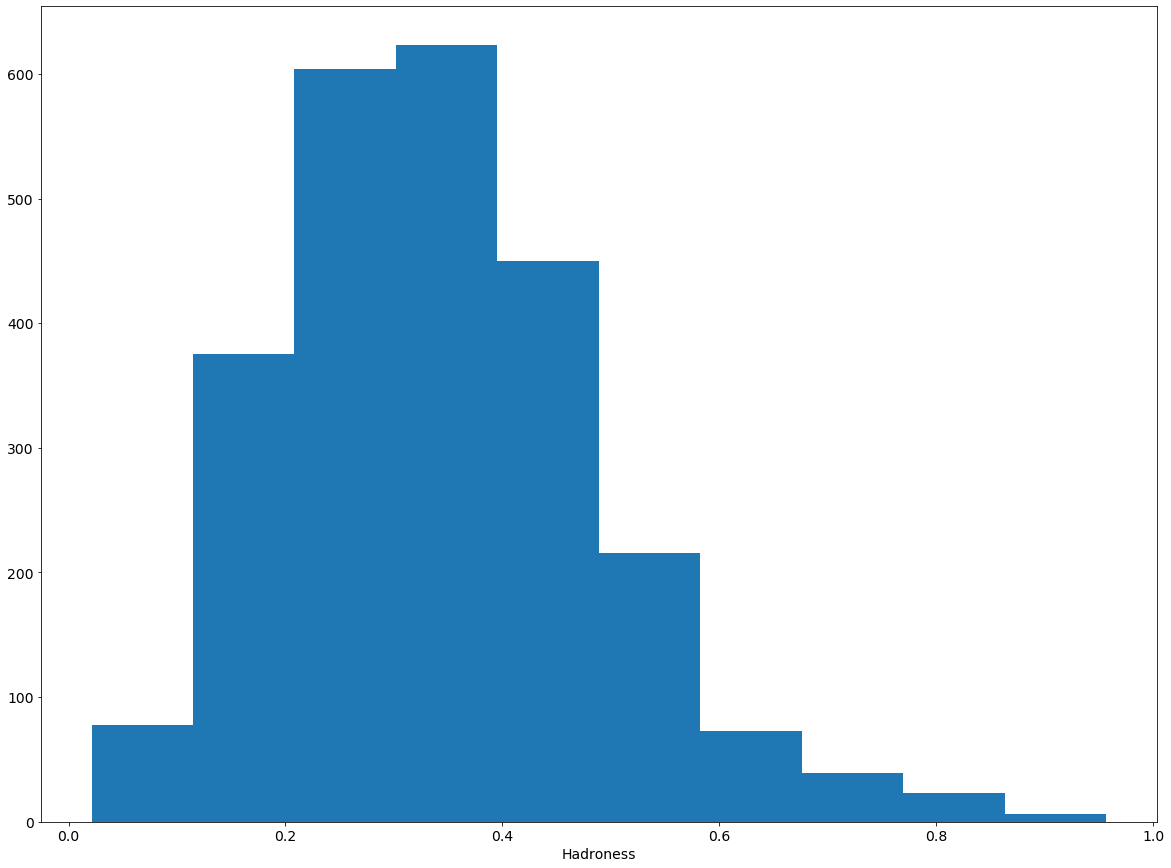

In [20]:
# var hadro_red deprecated. And we have loaded a file only of gammas...
plt.hist(1-data_dl2['gammaness'])
plt.xlabel('Hadroness')